Program: Star Cluster Age Distibution Analysis V2.0
Programmer: Benjamin Pieczynski
Date Rewritten: 04-21-22
Originally Version: 01-24-2019

In [8]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs.utils import skycoord_to_pixel
from numpy import sqrt
import pandas as pd
import csv
from astropy.table import vstack, Table, Column
from tabulate import tabulate
from astropy.coordinates import SkyCoord
import astropy.units as u

In [9]:
# reset defalult plotting values
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams.update({'font.size': 20})

## Image loading

In [10]:
def load_image(PATH, mn, mx, Title):
    hdul = fits.open(PATH)
    image = np.log(hdul[0].data)
    fig = plt.figure(figsize=(10,10),facecolor=(1, 1, 1))
    #plt.imshow(image, cmap = 'gray')
    hdul.info()
    wcs = WCS(header=hdul[0].header)
    plt.subplot(projection=wcs)
    plt.imshow(image, cmap = 'gray', vmin=mn, vmax=mx)
    plt.title(Title)
    #plt.colorbar(im)
    plt.savefig('figures/3.6_micron.png')
    return wcs

Filename: NGC_1566_3.6.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1655   (1898, 1713)   float32   


/var/folders/1l/xmxtwz3j281_tpjl7751_58w0000gn/T/ipykernel_55130/548052882.py:3: RuntimeWarning: invalid value encountered in log
  image = np.log(hdul[0].data)


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


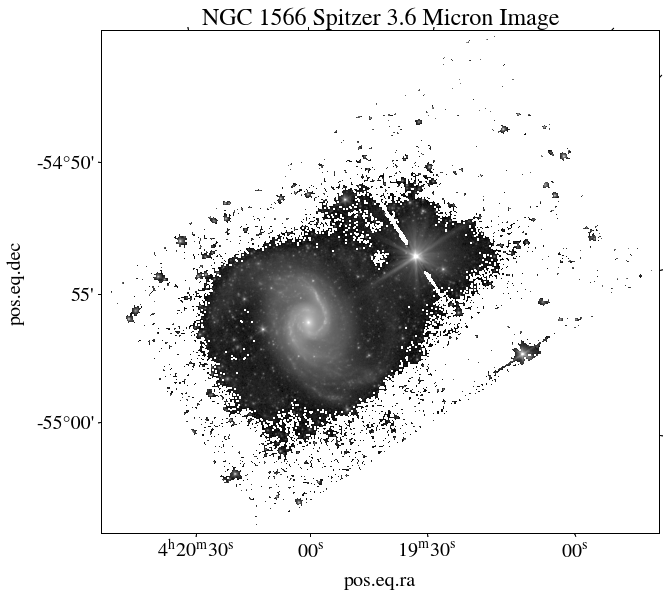

In [11]:
# Command Example
wcs = load_image('NGC_1566_3.6.fits',-5,4,'NGC 1566 Spitzer 3.6 Micron Image')

## Getting Cluster Data from LEGUS

legus data is available here: https://archive.stsci.edu/prepds/legus/dataproducts-public.html

In [12]:
# be sure to read the read me in the LEGUS cluster files as the index will change
def load_clusters(PATH):
    DATA = np.genfromtxt(PATH, skip_header=False, delimiter='', unpack=True)
    #X = DATA[1] # from HST image
    #Y = DATA[2] # from HST image
    RA = DATA[3]
    DEC = DATA[4]
    age = DATA[16]/1e6
    h_age = DATA[17]/1e6
    l_age = DATA[18]/1e6
    mass = DATA[19]
    obj_list = [RA,DEC,age,h_age,l_age,mass]
    header = ['RA','DEC','best age','max age', 'min_age', 'mass']
    table = Table(obj_list, names = header)
    w = table['best age'] != 0.0
    table = table[w]
    w = table['best age'] < 10000 # some data might be erroneous
    table = table[w]
    return table

In [13]:
# Command
cluster_DATA = load_clusters('ngc1566_clusters.tab') # change to chosen table
cluster_DATA

RA,DEC,best age,max age,min_age,mass
float64,float64,float64,float64,float64,float64
65.00739,-54.90761,15.0,15.0,15.0,13180.0
65.00608,-54.90799,10.0,11.0,9.0,29490.0
65.00707,-54.90863,1.0,1.0,1.0,3213.0
65.00715,-54.90873,1.0,2.0,1.0,1610.0
65.00023,-54.90918,40.0,40.0,30.0,236700.0
65.00055,-54.90922,200.0,200.0,90.0,330200.0
...,...,...,...,...,...
65.00562,-54.96373,1.0,1.0,1.0,8723.0
65.00484,-54.96379,8.0,8.0,8.0,2808.0


In [14]:
# We need to convert cluster wcs coordinates to pixels in the spitzer image
def cluster_coords(DATA, wcs):
    x = []
    y = []
    for c in DATA:
        ra = c['RA']
        dec = c['DEC']
        coords = SkyCoord(ra, dec, unit="deg")
        pixels = skycoord_to_pixel(coords, wcs, 0)
        x.append(pixels[0])
        y.append(pixels[1])
    DATA.add_column(y, name='y', index=0)
    DATA.add_column(x, name='x', index=0)
    return DATA

In [15]:
# Example
cluster_DATA = cluster_coords(cluster_DATA, wcs)
cluster_DATA

x,y,RA,DEC,best age,max age,min_age,mass
float64,float64,float64,float64,float64,float64,float64,float64
689.3625302561884,860.8951727135529,65.00739,-54.90761,15.0,15.0,15.0,13180.0
692.9792603914541,859.0768352313767,65.00608,-54.90799,10.0,11.0,9.0,29490.0
690.2528317647044,855.9876156685764,65.00707,-54.90863,1.0,1.0,1.0,3213.0
690.0328918409584,855.5056738831197,65.00715,-54.90873,1.0,2.0,1.0,1610.0
709.1296548933844,853.4027044844282,65.00023,-54.90918,40.0,40.0,30.0,236700.0
708.2465090556749,853.2069656075486,65.00055,-54.90922,200.0,200.0,90.0,330200.0
...,...,...,...,...,...,...,...
694.2412496118953,590.915825959546,65.00562,-54.96373,1.0,1.0,1.0,8723.0
696.401081032873,590.6185822945512,65.00484,-54.96379,8.0,8.0,8.0,2808.0


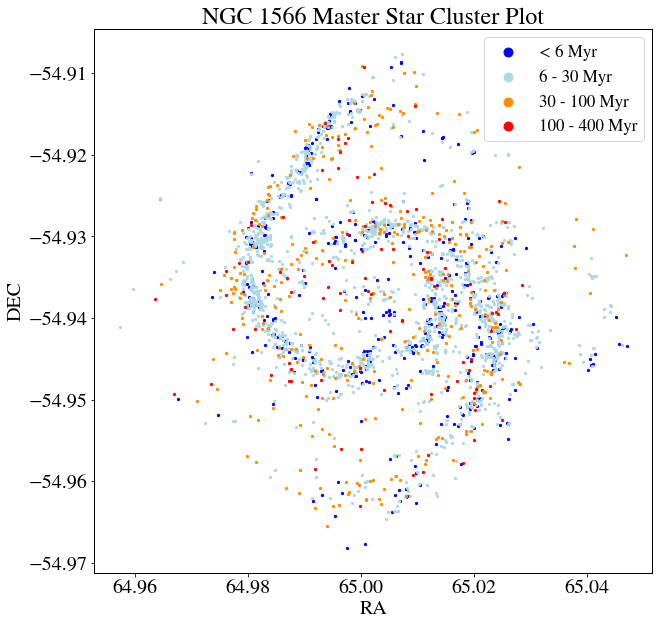

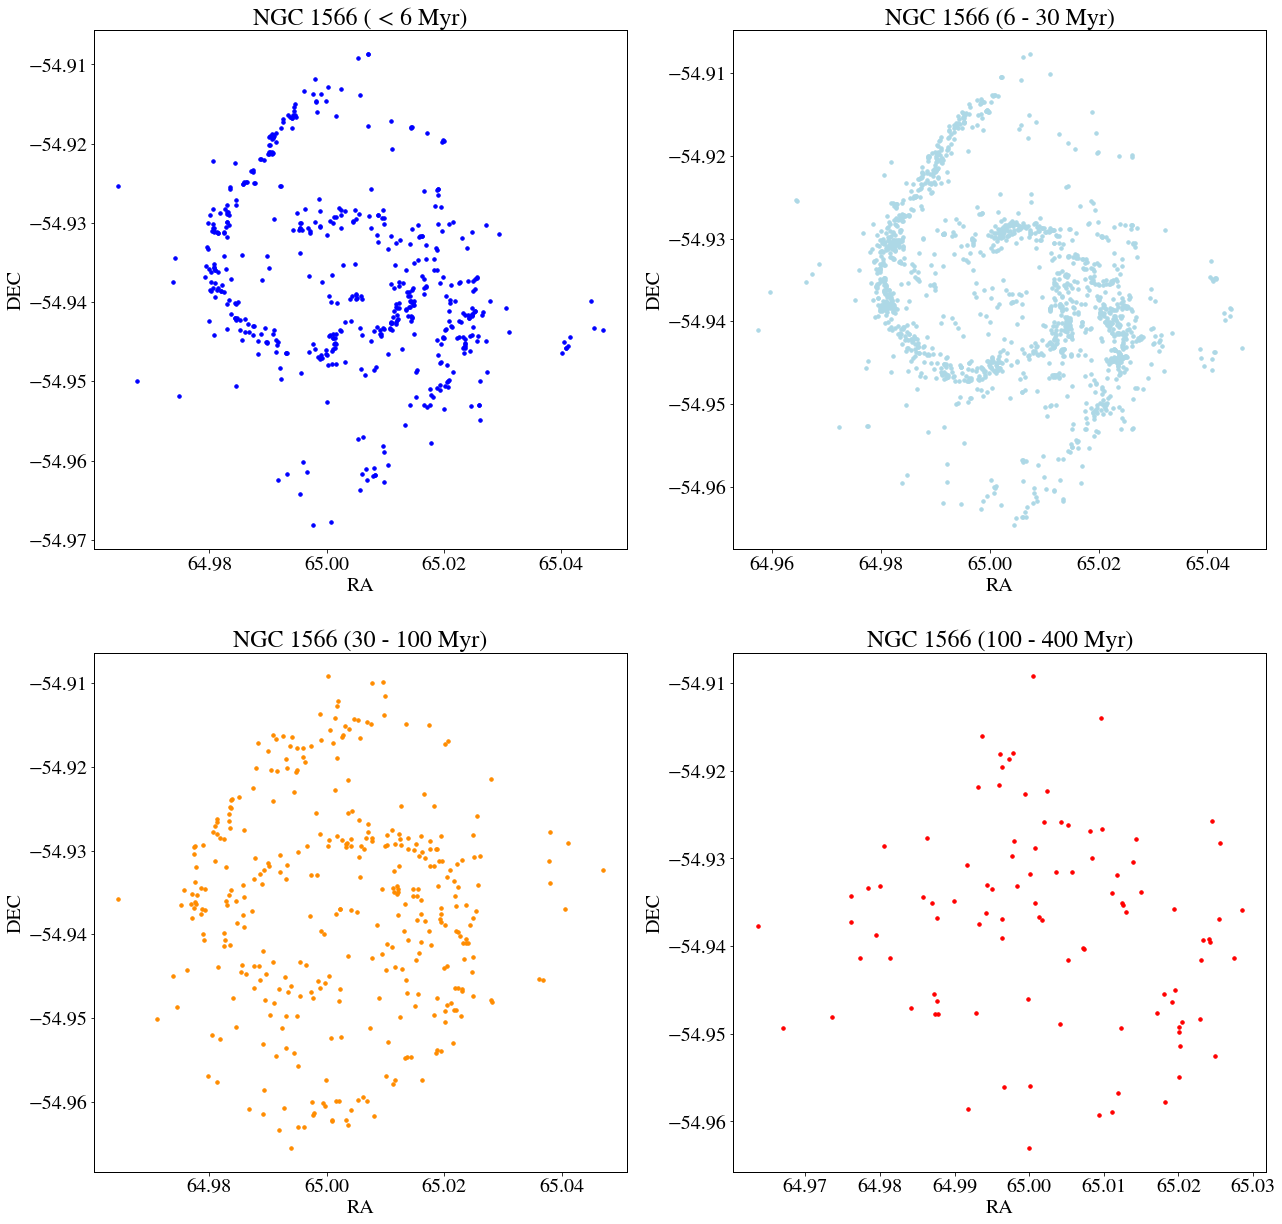

In [16]:
# We want to plot clusters of different ages here
# Modify to look at different ages
w = cluster_DATA['best age'] < 6
L6 = cluster_DATA[w]
w = cluster_DATA['best age'] >= 6
L30 = cluster_DATA[w]
w = L30['best age'] < 30
L30 = L30[w]
w = cluster_DATA['best age'] >= 30
L100 = cluster_DATA[w]
w = L100['best age'] < 100
L100 = L100[w]
w = cluster_DATA['best age'] >= 100
L400 = cluster_DATA[w]
w = L400['best age'] <= 400
L400 = L400[w]

plt.figure(figsize=(10,10), facecolor=(1, 1, 1))
plt.title('NGC 1566 Master Star Cluster Plot')
plt.ylabel('DEC')
plt.xlabel('RA')
plt.scatter(L6['RA'], L6['DEC'], c='b', s=5, label='< 6 Myr')
plt.scatter(L30['RA'], L30['DEC'], c='lightblue', s=5, label='6 - 30 Myr')
plt.scatter(L100['RA'], L100['DEC'], c='darkorange', s=5, label='30 - 100 Myr')
plt.scatter(L400['RA'], L400['DEC'], c='r', s=5, label='100 - 400 Myr')
plt.gca().legend(markerscale=4, fontsize=17, bbox_to_anchor = (1, 1))
#plt.gca().invert_xaxis()
plt.savefig('figures/master_clust.png')

# Subplots
fig, ax = plt.subplots(2, 2, figsize=(21,21), facecolor=(1, 1, 1))

ax[0,0].scatter(L6['RA'], L6['DEC'], c='b', s=12, label='< 6 Myr')
ax[0,0].set_title('NGC 1566 ( < 6 Myr)', fontsize=24)
ax[0,0].set(xlabel="RA", ylabel="DEC")

ax[0,1].scatter(L30['RA'], L30['DEC'], c='lightblue', s=12, label='6 - 30 Myr')
ax[0,1].set_title('NGC 1566 (6 - 30 Myr)', fontsize=24)
ax[0,1].set(xlabel="RA", ylabel="DEC")

ax[1,0].scatter(L100['RA'], L100['DEC'], c='darkorange', s=12, label='30 - 100 Myr')
ax[1,0].set_title('NGC 1566 (30 - 100 Myr)', fontsize=24)
ax[1,0].set(xlabel="RA", ylabel="DEC")

ax[1,1].scatter(L400['RA'], L400['DEC'], c='r', s=12, label='100 - 400 Myr')
ax[1,1].set_title('NGC 1566 (100 - 400 Myr)', fontsize=24)
ax[1,1].set(xlabel="RA", ylabel="DEC")

plt.show()

fig.savefig('figures/seperate_clusters.png')

/var/folders/1l/xmxtwz3j281_tpjl7751_58w0000gn/T/ipykernel_55130/164674276.py:3: RuntimeWarning: invalid value encountered in log
  image = np.log(hdul[0].data)


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


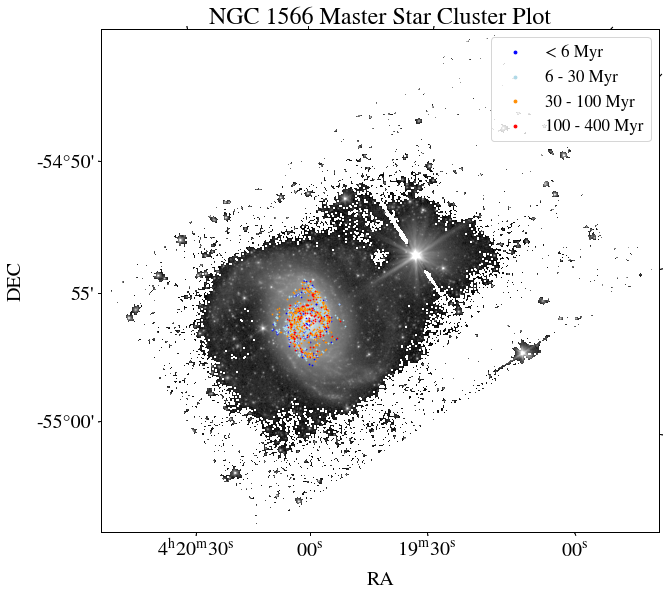

In [17]:
# plotting all star clusters over the 3.6 micron image
# requires editing to specify cluster ages and image files
hdul = fits.open('NGC_1566_3.6.fits')
image = np.log(hdul[0].data)
plt.figure(figsize=(10,10), facecolor=(1, 1, 1))
wcs = WCS(header=hdul[0].header)
plt.subplot(projection=wcs)
plt.title('NGC 1566 Master Star Cluster Plot')
plt.ylabel('DEC')
plt.xlabel('RA')
plt.scatter(L6['x'], L6['y'], c='b', s=0.5, label='< 6 Myr')
plt.scatter(L30['x'], L30['y'], c='lightblue', s=0.5, label='6 - 30 Myr')
plt.scatter(L100['x'], L100['y'], c='darkorange', s=0.5, label='30 - 100 Myr')
plt.scatter(L400['x'], L400['y'], c='r', s=0.5, label='100 - 400 Myr')
plt.imshow(image, cmap = 'gray', vmin=-5, vmax=2)
plt.gca().legend(markerscale=4, fontsize=17, bbox_to_anchor = (1, 1))
plt.savefig('figures/3.6_clusters.png')

## Spiral Arm Builder

In [18]:
def arm_section(a,i,l,h,xc,yc,seg_name):
    # a - amplitude
    # i - pitch angle
    # phi - polar angle
    # l, h: polar angle low and high
    # xc, yc - starting coordinates
    # seg_name - label for the arm segment
    x = []
    y = []
    seg = []
    angle = []
    for phi in np.linspace(l,h,100):
        x.append(a*np.exp((np.pi - phi)*np.tan(i))*np.cos(phi) + xc)
        y.append(-a*np.exp(-(np.pi - phi)*np.tan(i))*np.sin(phi) + yc)
        seg.append(seg_name)
        angle.append(phi)

    table = Table([x, y, angle, seg], names = ['x', 'y', 'angle', 'name'])
    return table

In [19]:
def bar_arm(x1, y1, x2, y2, seg_name):
    # enter start and end point
    x = []
    y = []
    seg = []
    angle = []
    m = (y1-y2)/(x1-x2)
    xc = x1
    x2 = x2 - x1
    x1 = 0
    for l in np.linspace(x1,x2,100):
        y.append(m*l+y1)
        x.append(l+xc)
        seg.append(seg_name)
        angle.append(0) # note we will not have an angle for bars so we default to 0
    
    table = Table([x, y, angle, seg], names = ['x', 'y', 'angle', 'name'])
    return table

In [20]:
def ellipse_arm(a, b, l, h, xc, yc, seg_name):
    # a - x semi axis
    # b - y semi axis
    # h - high limit in radians
    # l - low limit in radians
    x = []
    y = []
    seg = []
    angle = []
    for theta in np.linspace(l,h,100):
        x.append(a*np.cos(theta) + xc)
        y.append(b*np.sin(theta) + yc)
        seg.append(seg_name)
        angle.append(theta)

    table = Table([x, y, angle, seg], names = ['x', 'y', 'angle', 'name'])
    return table  

In [21]:
# testing plot of arms
def arm_plot(seg_list, PATH, mn, mx, pkx, pky, label_list):
    hdul = fits.open(PATH)
    image = np.log(hdul[0].data)
    plt.figure(figsize=(10,10), facecolor=(1, 1, 1))
    plt.scatter(pkx,pky, c='white', marker ="^", s=40, edgecolors='black',
                zorder=10, label='3.6 micron peaks')
    n=0
    for seg in seg_list:
        plt.plot(seg['x'], seg['y'], lw=2,label=label_list[n],zorder=4)
        plt.scatter(seg['x'][0], seg['y'][0], c='darkorange', s=24, zorder=2)
        plt.scatter(seg['x'][-1], seg['y'][-1], c='darkorange', s=24, zorder=3)
        n+=1

    plt.imshow(image, cmap = 'gray', vmin=mn, vmax=mx)
    plt.title('NGC 1566 Spiral Arm Plot')
    plt.xlabel('pixels', fontsize=23)
    plt.ylabel('pixels', fontsize=23)
    plt.xlim([340, 1100]) # edit to users liking
    plt.ylim([1060, 370]) # edit to users liking
    plt.gca().legend(markerscale=2, fontsize=17, bbox_to_anchor = (1.4,1))
    plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    plt.savefig('figures/arm_plot.png')
    return

In [22]:
# arms with clusters
def arm_cluster_plot(seg_list, PATH, mn, mx, pkx, pky, label_list):
    hdul = fits.open(PATH)
    image = np.log(hdul[0].data)
    plt.figure(figsize=(10,10), facecolor=(1, 1, 1))
    plt.scatter(pkx,pky, c='white', marker ="^", edgecolors='black', 
                s=40, zorder=10, label='3.6 micron peaks')
    n=0
    for seg in seg_list:
        plt.plot(seg['x'], seg['y'], lw=2,label=label_list[n],zorder=4)
        plt.scatter(seg['x'][0], seg['y'][0], c='darkorange', s=24, zorder=2)
        plt.scatter(seg['x'][-1], seg['y'][-1], c='darkorange', s=24, zorder=3)
        n+=1
    
    plt.scatter(L6['x'], L6['y'], c='b', s=2.5, label='< 6 Myr',zorder=1)
    plt.scatter(L30['x'], L30['y'], c='lightblue', s=2.5, label='6 - 30 Myr', zorder=1)
    plt.scatter(L100['x'], L100['y'], c='darkorange', s=2.5, label='30 - 100 Myr', zorder=1)
    plt.scatter(L400['x'], L400['y'], c='r', s=2.5, label='100 - 400 Myr', zorder=3)
    plt.imshow(image, cmap = 'gray', vmin=mn, vmax=mx)
    plt.title('NGC 1566 Spiral Arm Plot')
    plt.xlabel('pixels', fontsize=23)
    plt.ylabel('pixels', fontsize=23)
    plt.xlim([340, 1100]) # edit to users liking
    plt.ylim([1060, 370]) # edit to users linking
    plt.gca().legend(markerscale=2, fontsize=17, bbox_to_anchor = (1.4,1))
    plt.gca().invert_yaxis()
    #plt.gca().invert_xaxis()
    plt.savefig('figures/arm_cluster.png')
    return

### Currently optical peaks must be manually entered. Future plans include plans for some automation. Current recommendation is to use contor plots from DS9 software to determine $3.6 \mu m$ peak location.

In [23]:
# optical peaks: from contour plots
peaks_36 = [(709,677),(744,690),(762,718),(763,750),(755,767),(748,778),(737,796),
           (732,813),(685,842),(721,858),(705,757),(675,743),(660,726),(654,709),
           (643,698),(645,679),(654,709),(643,698),(645,679),(654,655),(671,602),(724,600)]

peaks_x = []
peaks_y = []
for pk in peaks_36:
    peaks_x.append(pk[0])
    peaks_y.append(pk[1])

### This section is for editing the spiral arms using pixel location.

### arm_section(a, i, l, h, xc, yc, seg_name):
    
    # a - amplitude
    
    # i - pitch angle
    
    # phi - polar angle
    
    # l, h: polar angle low and high
    
    # xc, yc - starting coordinates
    
    # seg_name - label for the arm segment
    
### ellipse_arm(a, b, l, h, xc, yc, seg_name):

    # a - x semi axis
    
    # b - y semi axis
    
    # h - high limit in radians
    
    # l - low limit in radians
    
### bar_arm(x1, y1, x2, y2, seg_name):

    # x1,y1,x2,y2 are starting anf ending points

/var/folders/1l/xmxtwz3j281_tpjl7751_58w0000gn/T/ipykernel_55130/1053311756.py:4: RuntimeWarning: invalid value encountered in log
  image = np.log(hdul[0].data)


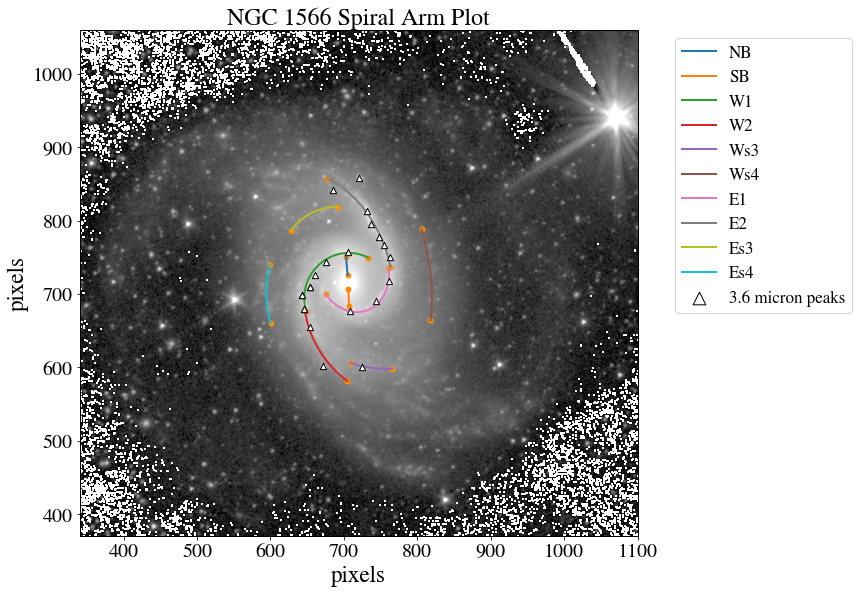

In [24]:
# Example
NB = bar_arm(705,726,703,750,'NB')
SB = bar_arm(706,707,707,683,'SB')

W1 = arm_section(60,0.01,0.9*np.pi,1.65*np.pi,706,695,'W1')
W2 = arm_section(120,-0.05,0.68*np.pi,0.97*np.pi,766,688,'W2')
Ws3 = arm_section(125,0.06,0.5*np.pi,0.64*np.pi,766,712,'Ws3')
Ws4 = arm_section(80,3.008,0.13*np.pi,-0.2*np.pi,767,710,'Ws4')
#Ws5 = arm_section(160,-0.05,0.5*np.pi,0.83*np.pi,770,673,'Ws5')
#Ws6 = arm_section(140,-0.08,0.4*np.pi,0.7*np.pi,774,624,'Ws6')
#Ws7 = arm_section(240,0.035,0.26*np.pi,0.43*np.pi,782,728,'Ws7')
E1 = arm_section(52,-0.042,-0.02*np.pi,0.8*np.pi,716,731,'E1')
E2 = arm_section(143,-0.033,-0.4*np.pi,-0.075*np.pi,639,700,'E2')
Es3 = arm_section(79,0.0,-0.8*np.pi,-0.5*np.pi,692,740,'Es3')
Es4 = arm_section(120,-0.01,-0.9*np.pi,-1.1*np.pi,707,700,'Es4')
C = ellipse_arm(2, 2, 0, 2*np.pi, 706, 716, 'Center')
label_list = ['NB', 'SB', 'W1', 'W2', 'Ws3', 'Ws4', 
              'E1', 'E2', 'Es3', 'Es4']
seg_list = [NB, SB, W1, W2, Ws3, Ws4, 
            E1, E2, Es3, Es4]
arm_plot(seg_list, 'NGC_1566_3.6.fits', -5, 2, peaks_x, peaks_y, label_list)

/var/folders/1l/xmxtwz3j281_tpjl7751_58w0000gn/T/ipykernel_55130/2067071502.py:4: RuntimeWarning: invalid value encountered in log
  image = np.log(hdul[0].data)


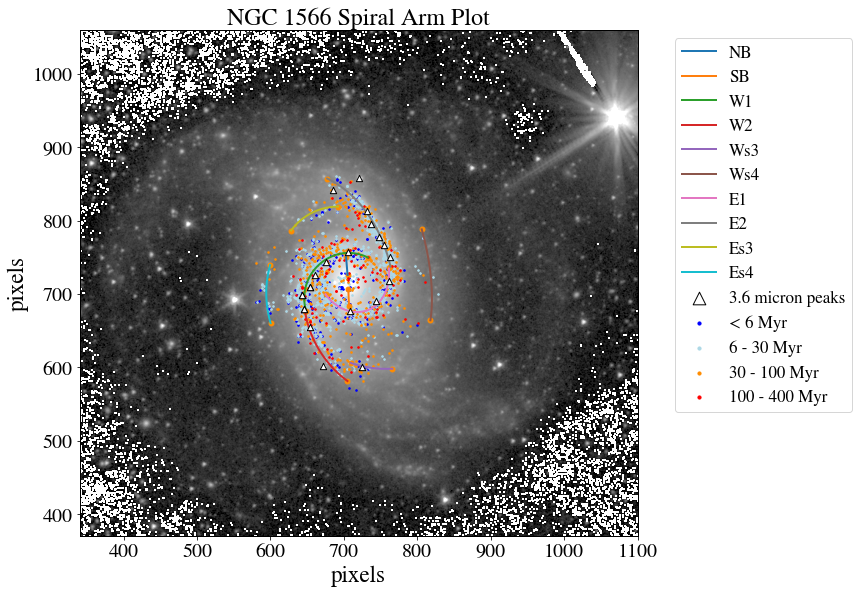

In [25]:
# plot of arms and clusters
arm_cluster_plot(seg_list, 'NGC_1566_3.6.fits', -5, 2, peaks_x, peaks_y, label_list)

In [26]:
# Once the arms are well defined we merge the coordinate data for every segment
Master_ARM = vstack(seg_list)
Master_ARM

x,y,angle,name
float64,float64,float64,str3
705.0,726.0,0.0,NB
704.979797979798,726.2424242424242,0.0,NB
704.959595959596,726.4848484848485,0.0,NB
704.939393939394,726.7272727272727,0.0,NB
704.9191919191919,726.969696969697,0.0,NB
704.89898989899,727.2121212121212,0.0,NB
...,...,...,...
598.8744761913814,665.0721710085443,-3.417672007996169,Es4
599.0779225801472,664.2881789584494,-3.424018659821603,Es4


## Assigning clusters to arm segments

In [27]:
def calculate_kpc_px(px_scale, d):
    # px_scale is available in .fits header in arcsec
    # d is the cited distance to the object in Mpc
    
    # convert d to kpc
    d = d*1e6/1e3
    
    # convert px_scale to radians
    px_scale = px_scale/3600/360*2*np.pi
    
    # solve
    kpc_px = d*np.sin(px_scale)
    print(kpc_px, 'kpx per pixel')
    
    return kpc_px


    # be sure to include pixel scale from the fits file

In [28]:
# example
kpc_px = calculate_kpc_px(1.22328355209902,21.3)

0.12632276021117478 kpx per pixel


In [29]:
arm_rad = 2 # kpc, default method is 2 based on Chandar et al. 2017 (M51)
def cluster_finder(ARM, CLUSTER, CTR):
    # ARM is the table containing all arm points
    # CLUSTER are all the cluster data 
    # CTR [x,y] coordinates of Galaxy center
    assign = [] 
    distances = []
    angle = [] # we need the polar angle for plots
    
    for c in CLUSTER:
        dist = []
        seg_name = []
        sign = [] # cluster on inside of arm or outside
        opp = [] # opposite side
        adj = [] # adjacent side
        hyp = [] # hypotenuse
        
        for p in ARM:
            d = np.sqrt( (p['x'] - c[0])**2 + (p['y'] - c[1])**2 ) * kpc_px
            dist.append(d)
            seg_name.append(p['name'])
            opp.append(p[1]-CTR[1])
            adj.append(p[0]-CTR[0])
            #temp_angle.append(p['angle'])
            
            # location relative to arm(inside or outside)
            cp_d = np.sqrt( (p['x'] - CTR[0])**2 + (p['y'] - CTR[1])**2 )
            cc_d = np.sqrt( (c[0] - CTR[0])**2 + (c[1] - CTR[1])**2 )
            arm_test = cp_d - cc_d
            hyp.append(cp_d)
            
            if arm_test > 0:
                sign.append(-1)
            elif arm_test < 0:
                sign.append(1)
            else:
                sign.append(1)
                
        min_dist = np.min(dist)
        n = 0
        for d in dist:
            if d == min_dist:
                idx = n
                n+=1
            else:
                n+=1
        
        # projection of cluster location onto the arm relative to the center (North of East)
        # based on the closest point in the arm to the cluster
        X = adj[idx]
        Y = opp[idx]
        Z = hyp[idx]
        y = abs(Y)
        if (X < 0 and Y <0):
            angle.append(np.arcsin(y/Z) / (2*np.pi) * 360 + 180)
        elif (X < 0 and Y > 0):
            angle.append(np.arcsin(y/Z) / (2*np.pi) * 360 + 90)
        elif (X > 0 and Y > 0):
            angle.append(np.arcsin(y/Z) / (2*np.pi) * 360)
        else:
            angle.append(np.arcsin(y/Z) / (2*np.pi) * 360 + 270)
        
        if min_dist <= arm_rad:
            assign.append(seg_name[idx])
            distances.append(min_dist*sign[idx])
            
        else:
            assign.append('N/A')
            distances.append(min_dist)
            
    # adding to table
    CLUSTER.add_column(distances, name='Dist [kpc]', index=-1)
    CLUSTER.add_column(assign, name='Arm', index=-1)
    CLUSTER.add_column(angle, name='Angle [deg]', index=-1)
    return

In [30]:
# Command Example
cluster_finder(Master_ARM, cluster_DATA, [706,716])

In [31]:
# checking data
cluster_DATA

x,y,RA,DEC,best age,max age,min_age,mass,Dist [kpc],Arm,Angle [deg]
float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64
689.3625302561884,860.8951727135529,65.00739,-54.90761,15.0,15.0,15.0,13180.0,1.119531263138081,E2,171.11605229919542
692.9792603914541,859.0768352313767,65.00608,-54.90799,10.0,11.0,9.0,29490.0,1.1512860704295107,E2,172.4698873162689
690.2528317647044,855.9876156685764,65.00707,-54.90863,1.0,1.0,1.0,3213.0,0.6426436276058232,E2,172.4698873162689
690.0328918409584,855.5056738831197,65.00715,-54.90873,1.0,2.0,1.0,1610.0,0.575725611679959,E2,172.4698873162689
709.1296548933844,853.4027044844282,65.00023,-54.90918,40.0,40.0,30.0,236700.0,1.726113911076152,E2,177.69868764421193
708.2465090556749,853.2069656075486,65.00055,-54.90922,200.0,200.0,90.0,330200.0,1.6400630352042342,E2,177.20363785335945
...,...,...,...,...,...,...,...,...,...,...
694.2412496118953,590.915825959546,65.00562,-54.96373,1.0,1.0,1.0,8723.0,-0.10354943501686802,W2,264.6520637271356
696.401081032873,590.6185822945512,65.00484,-54.96379,8.0,8.0,8.0,2808.0,-0.23346587380093062,W2,265.06979752145475


## DATA ANALYSIS

In [32]:
# change your lists as needed
A_list = ['W1','W2','E1','E2']
SA_list = ['Ws3','Ws4','Es3','Es4']
C_list = ['NB', 'SB']

In [33]:
# Arm Segment Histograms
def structure_histograms(DATA, label_list, bn, figure_size, filename):
    # label_list - list of arm segments you want to plot (equals columns)
    # rows - number of subplot rows
    # figure_size - tuple with figure size
    # bn - bin number
    
    # age list
    age_L = [' ( < 6 Myr)', ' (6 - 30 Myr)', ' (30 - 100 Myr)', ' (100 - 400 Myr)']
    cols = len(label_list)
    
    # Subplots
    fig, ax = plt.subplots(4, cols, figsize=(figure_size), facecolor=(1, 1, 1))
    
    cols = len(label_list)
    c = 0
    while c < cols:
        r = 0
        
        # filtering the data
        w = DATA['Arm'] == label_list[c]
        s_DATA = DATA[w]
        w = s_DATA['best age'] < 6
        L6 = s_DATA[w]
        w = s_DATA['best age'] >= 6
        L30 = s_DATA[w]
        w = L30['best age'] < 30
        L30 = L30[w]
        w = s_DATA['best age'] >= 30
        L100 = s_DATA[w]
        w = L100['best age'] < 100
        L100 = L100[w]
        w = s_DATA['best age'] >= 100
        L400 = s_DATA[w]
        w = L400['best age'] <= 400
        L400 = L400[w]
        ages = [L6,L30,L100,L400]
        while r < 4:
            t_string = label_list[c] + age_L[r]
            t_table = ages[r]
            c_dist = t_table['Dist [kpc]']
            ax[r,c].set_xlim([-2, 2])
            #ax[r,c].set_ylim([0, 1.5])
            ax[r,c].tick_params(axis='both', which='major', length=7, width=3, labelsize=24)
            ax[r,c].hist(c_dist, bins=bn, histtype="step", density=True, color='white',edgecolor='black', lw=3)
            ax[r,c].axvline(0, c='k', ls='--', lw=5)
            ax[r,c].set_title(t_string, fontsize=35)
            ax[r,c].set_xlabel("Distance [kpc]", fontsize = 32)
            ax[r,c].set_ylabel("(%)", fontsize = 35, labelpad=8)
            r+=1
        c+=1
        
    fn = 'figures/' + filename
    fig.savefig(fn)
    return

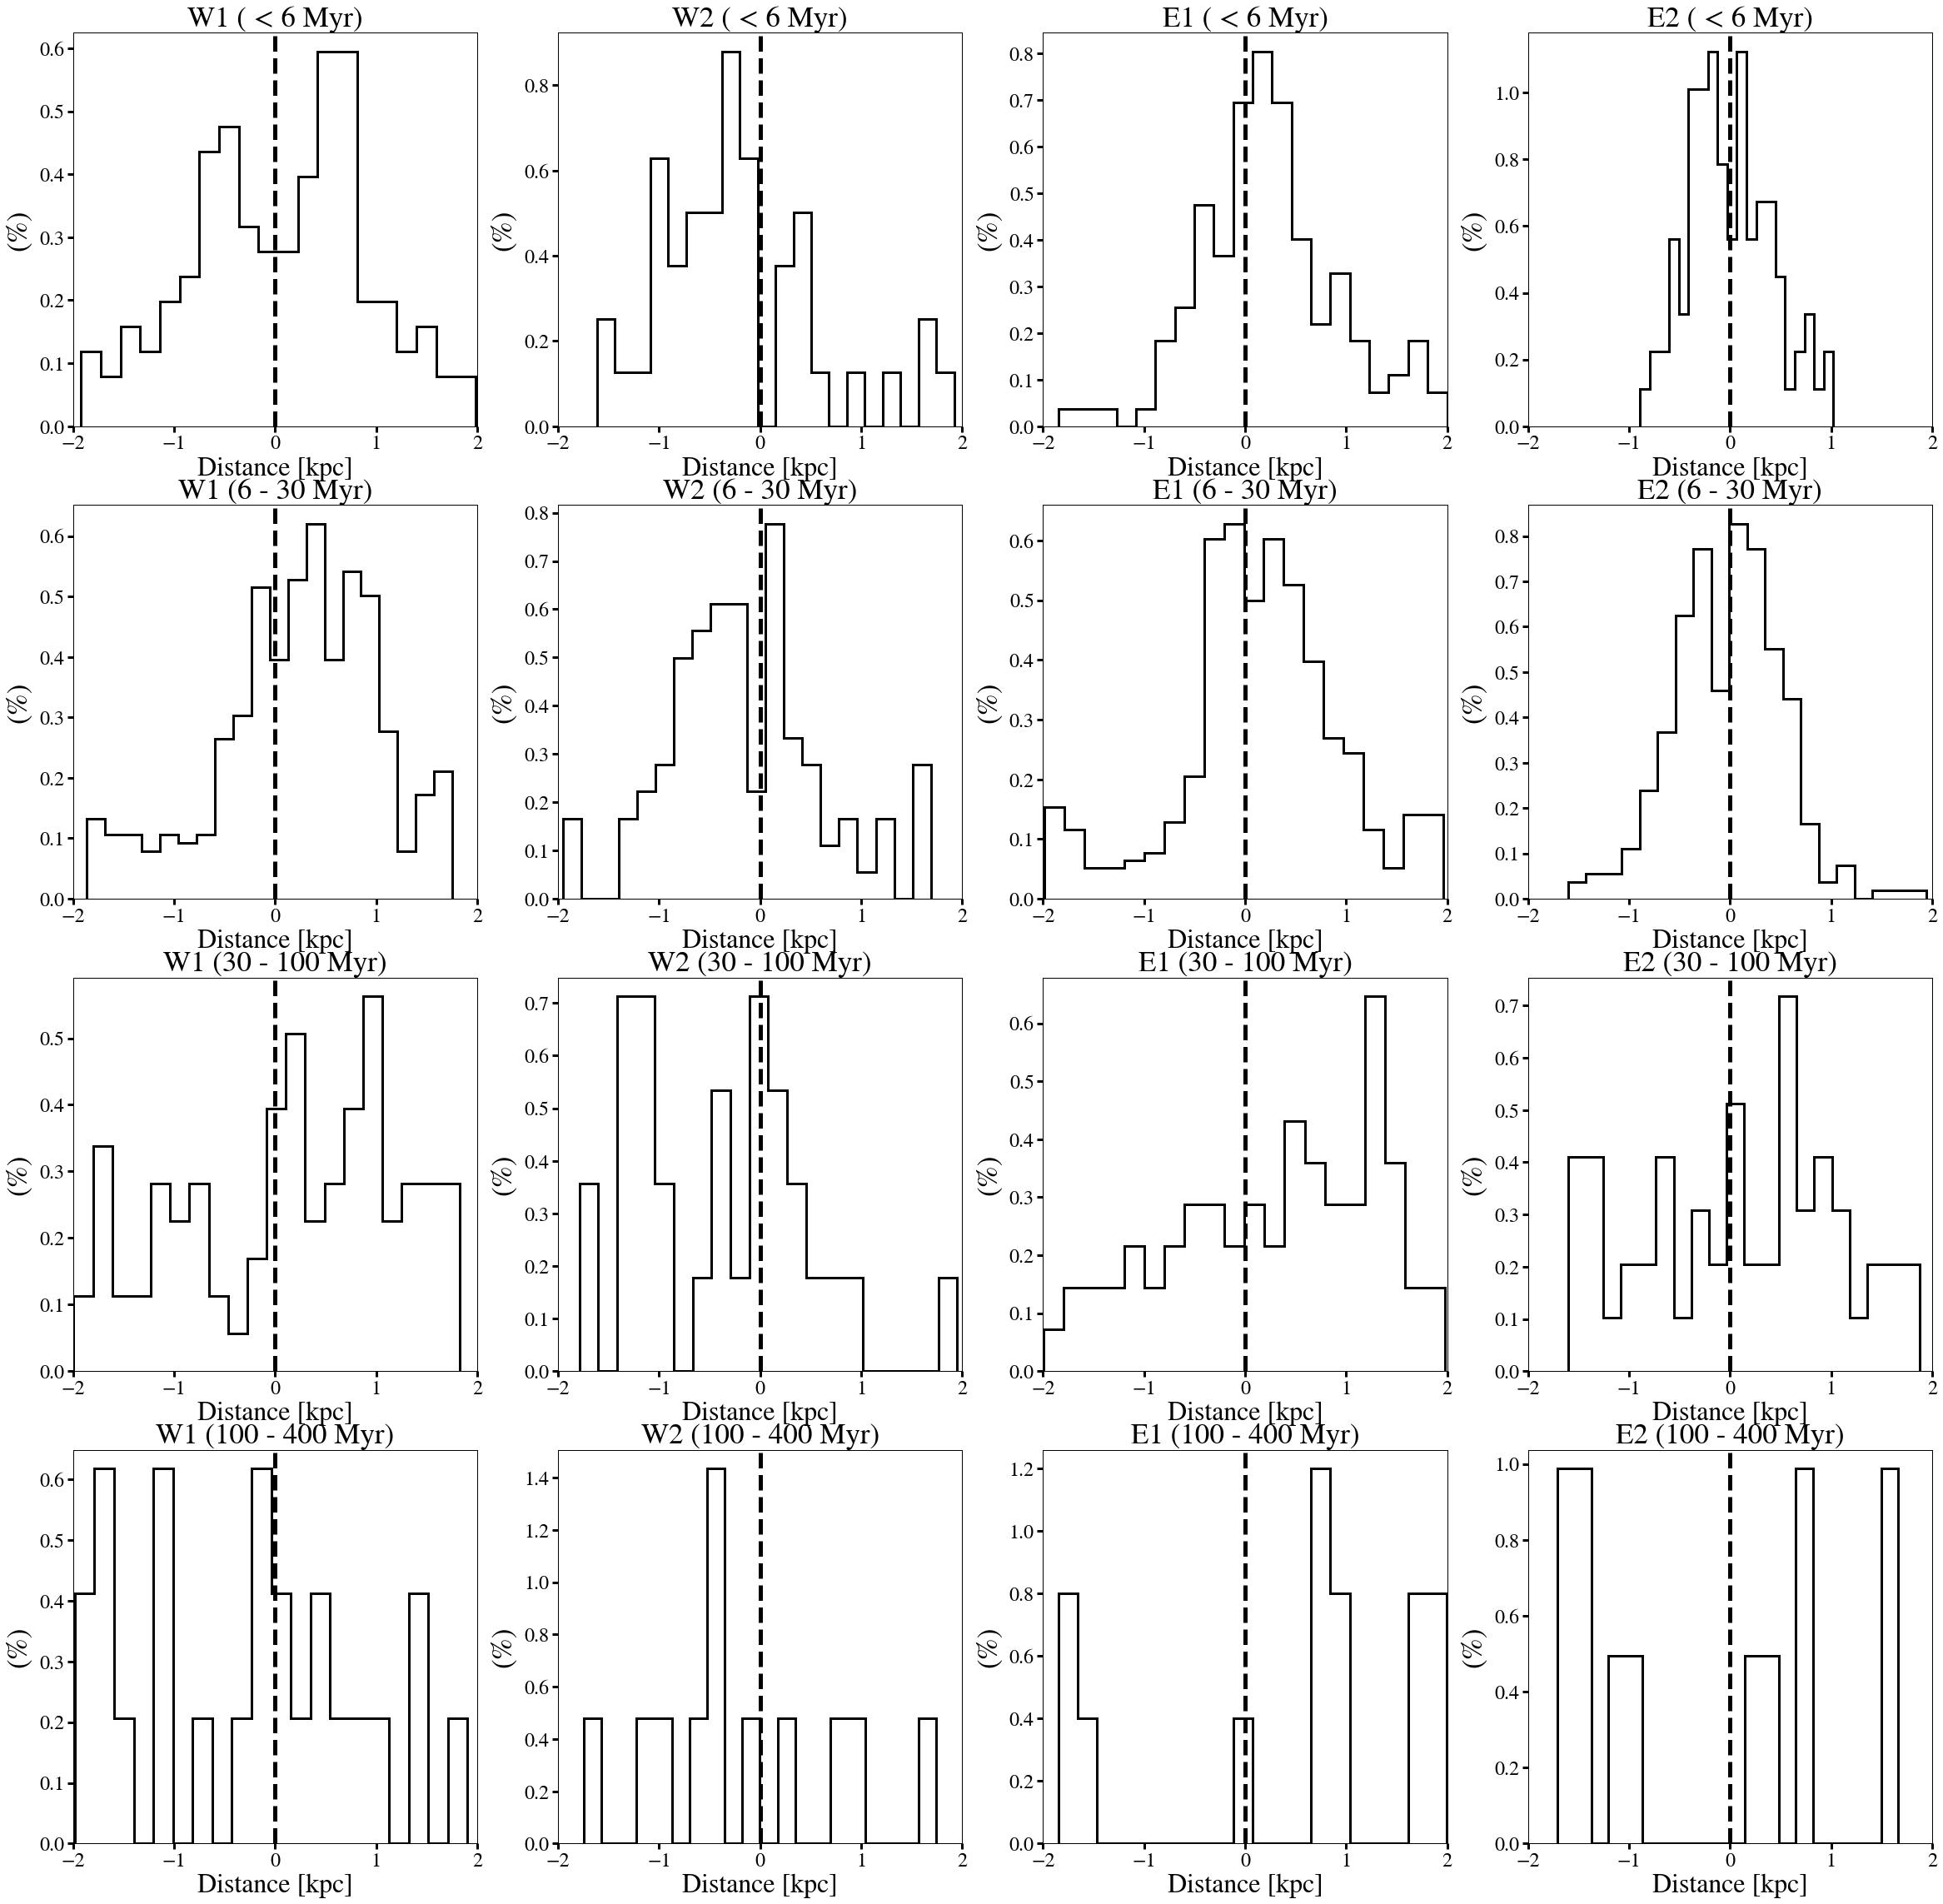

In [34]:
# Example
structure_histograms(cluster_DATA, A_list, 20, (40,40), 'arms_hist.png')

/usr/local/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


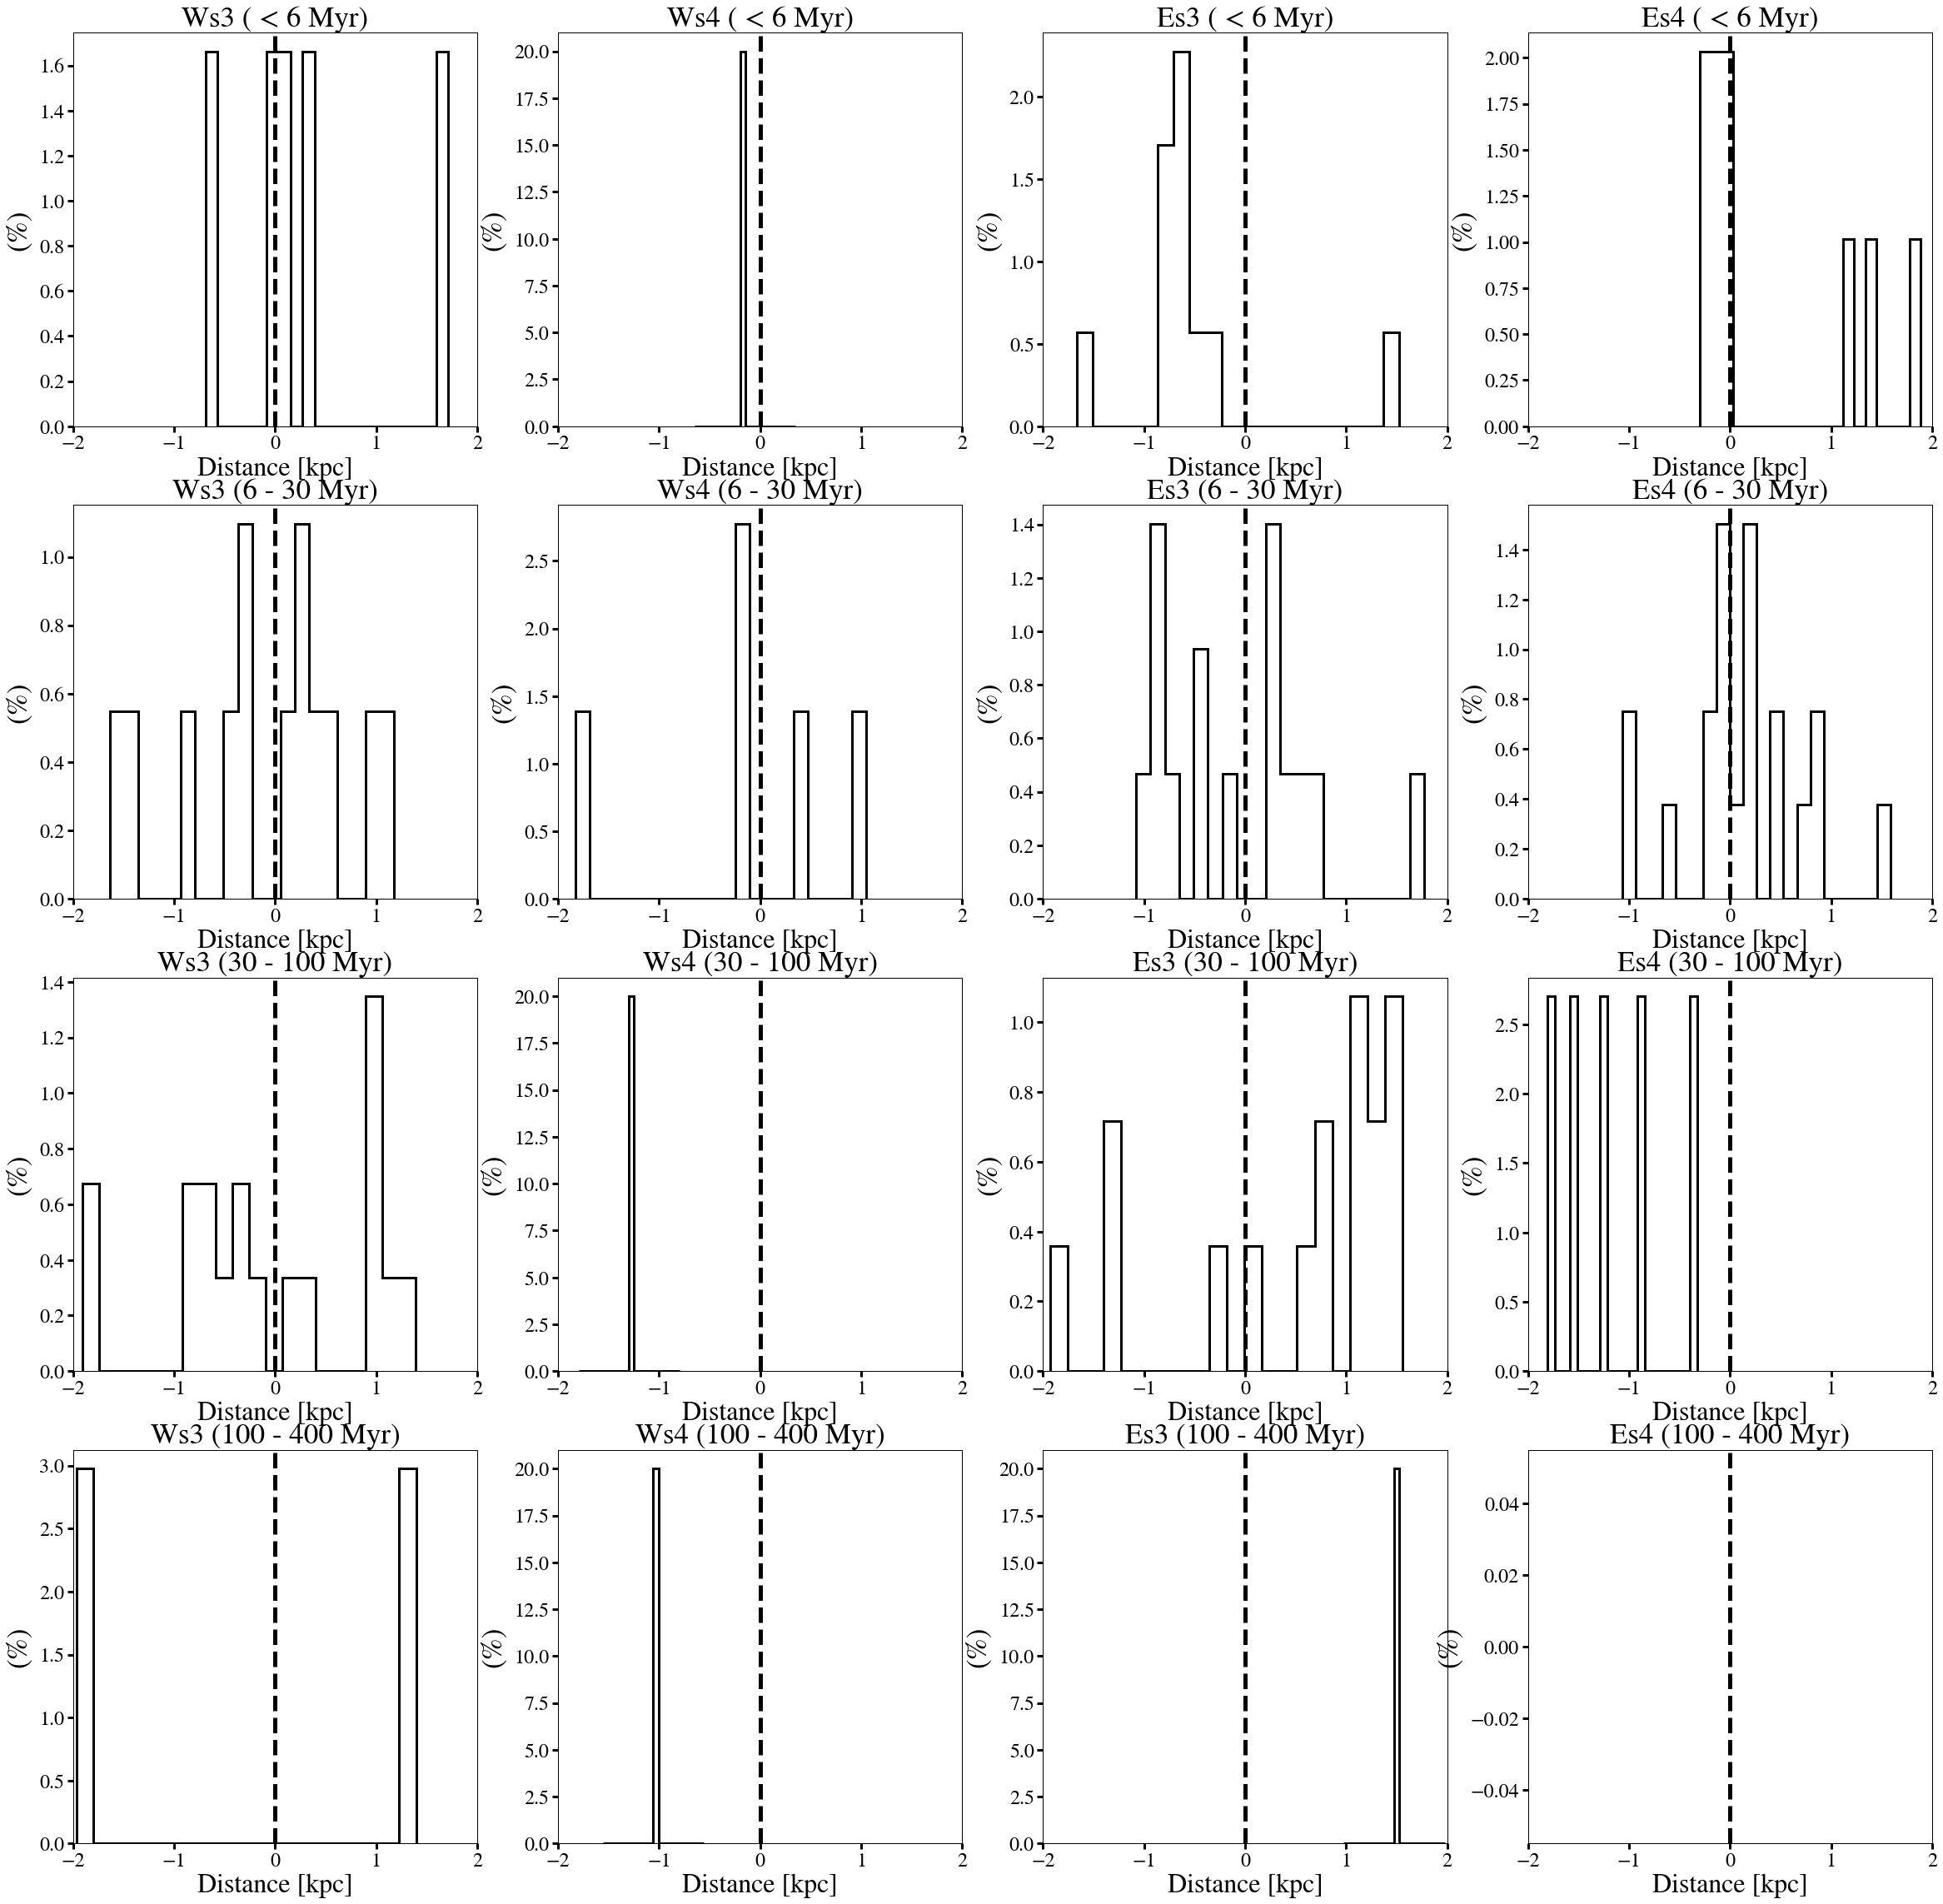

In [35]:
structure_histograms(cluster_DATA, SA_list, 20, (40,40), 'subarm_hist.png')

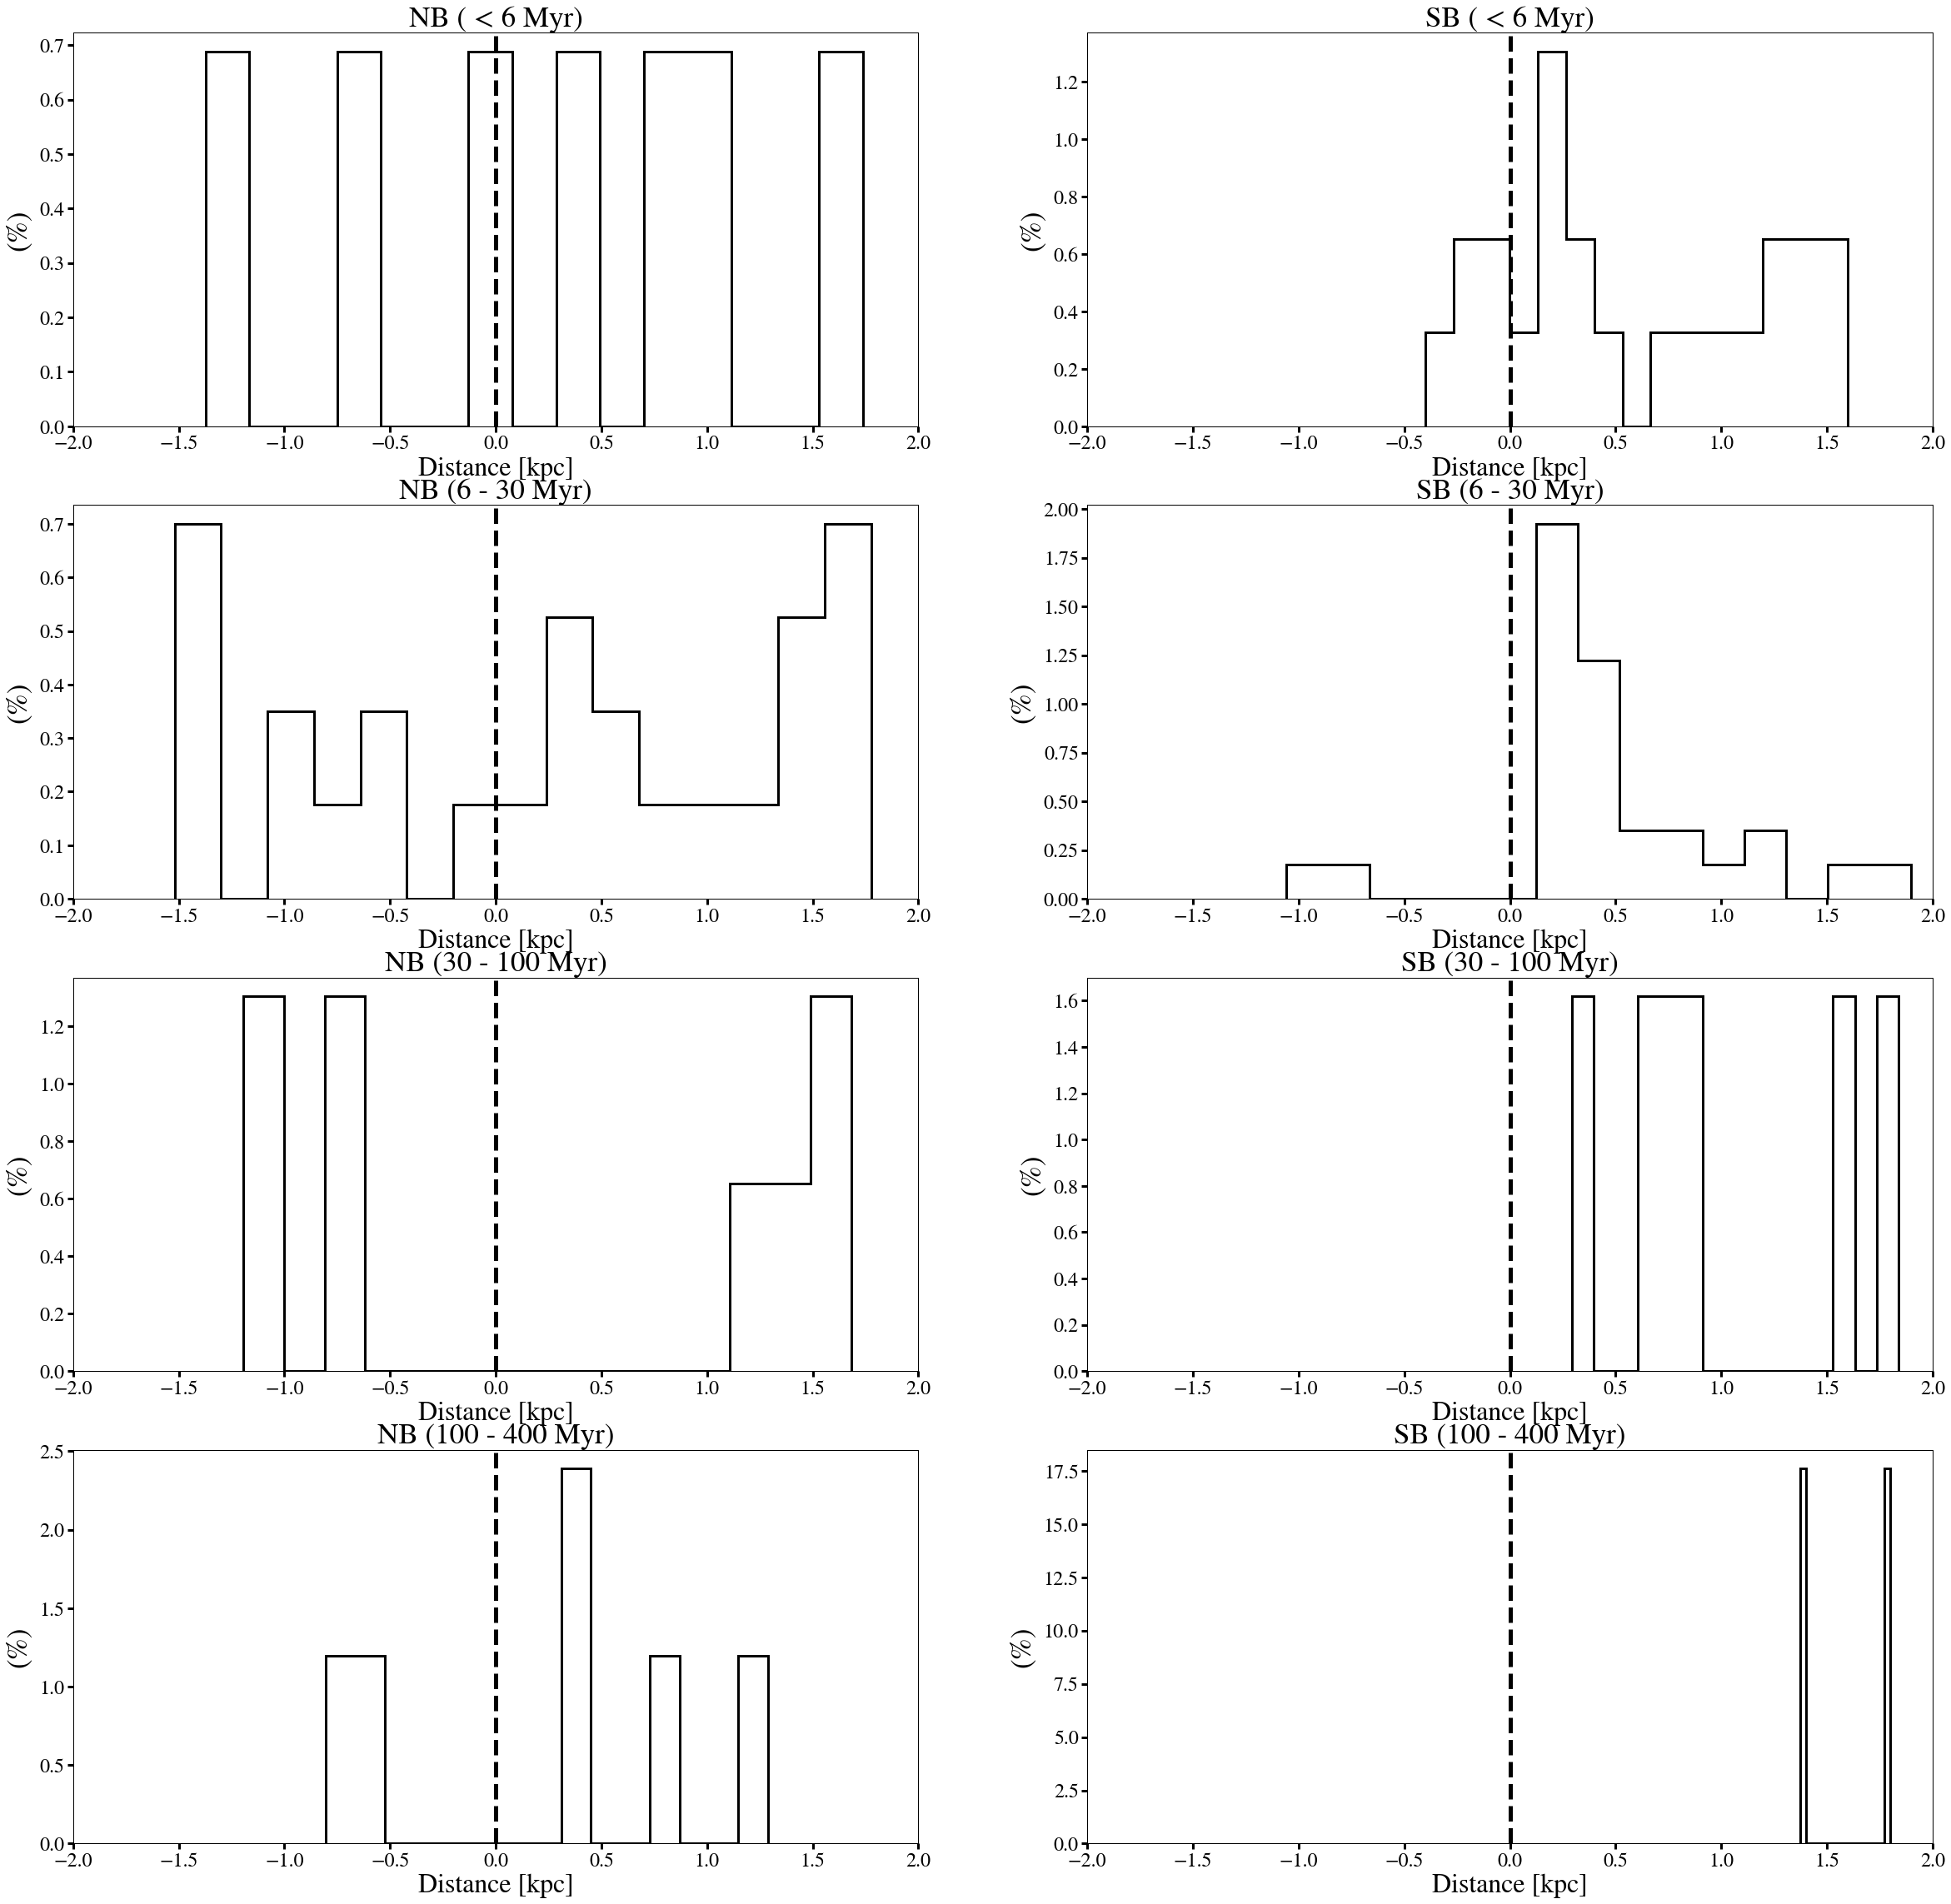

In [36]:
structure_histograms(cluster_DATA, C_list, 15, (40,40), 'bar_hists.png')

In [37]:
def stack_arms(DATA, label_list):
    # filtering the data
    s_Data = []
    c=0
    while c < len(label_list):
        w = DATA['Arm'] == label_list[c]
        s_Data.append(DATA[w])
        c+=1

    stacked_DATA = vstack(s_Data)
    return stacked_DATA

In [38]:
# combining the data in the arms
W_data = stack_arms(cluster_DATA, ['W1','W2'])
E_data = stack_arms(cluster_DATA, ['E1','E2'])

In [39]:
W_data

x,y,RA,DEC,best age,max age,min_age,mass,Dist [kpc],Arm,Angle [deg]
float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64
705.6801565532469,769.1247418676819,65.0015,-54.92673,13.0,40.0,1.0,9398.0,1.6647368539325322,W1,179.59673329178383
690.6079976411705,768.5785281553771,65.00697,-54.92684,40.0,70.0,6.0,56680.0,1.8238589624795267,W1,161.47148695778833
695.7320893414909,768.5367930409624,65.00511,-54.92685,15.0,20.0,13.0,7649.0,1.6965531624881685,W1,167.49069791966332
713.8410227096497,768.4163838880007,64.99854,-54.92688,9.0,15.0,9.0,4466.0,1.6223717934762638,W1,80.3667420444874
713.5928908968609,768.2721687811023,64.99863,-54.92691,15.0,15.0,15.0,6528.0,1.6017740809960466,W1,80.3667420444874
713.5378358169268,767.9843426802798,64.99865,-54.92697,1.0,1.0,1.0,8373.0,1.5650307389813738,W1,80.3667420444874
...,...,...,...,...,...,...,...,...,...,...
693.4388323278105,591.4527627556074,65.00591,-54.96362,9.0,15.0,9.0,2429.0,-0.07454553057474105,W2,264.2318671380892
691.4724813242588,591.2141842307993,65.00662,-54.96367,10.0,15.0,9.0,4471.0,0.14212747048018365,W2,263.8091702472232


In [40]:
# Arm Segment Histograms
def combined_histograms(DATA, label_list, bn, figure_size, filename):
    # label_list - list of arm segments you want to plot (equals columns)
    # rows - number of subplot rows
    # figure_size - tuple with figure size
    # bn - bin number
    
    # age list
    age_L = [' ( < 6 Myr)', ' (6 - 30 Myr)', ' (30 - 100 Myr)', ' (100 - 400 Myr)']
    
    # Subplots
    fig = plt.figure(figsize=(figure_size), facecolor=(1, 1, 1))
    ecs = ['blue', 'cyan', 'darkorange', 'red']
    
    # filtering the data
    s_DATA = DATA
    w = s_DATA['best age'] < 6
    L6 = s_DATA[w]
    w = s_DATA['best age'] >= 6
    L30 = s_DATA[w]
    w = L30['best age'] < 30
    L30 = L30[w]
    w = s_DATA['best age'] >= 30
    L100 = s_DATA[w]
    w = L100['best age'] < 100
    L100 = L100[w]
    w = s_DATA['best age'] >= 100
    L400 = s_DATA[w]
    w = L400['best age'] <= 400
    L400 = L400[w]
    ages = [L6,L30,L100,L400]
        
    # plotting
    n=0
    t_string = label_list
    plt.axvline(0, c='k', ls='--', lw=3, label='Arm Center')
    plt.title(t_string, fontsize=35)
    plt.xlabel("Distance [kpc]", fontsize = 32)
    plt.ylabel("# of Clusters", fontsize = 32, labelpad=8)
    plt.tick_params(axis='both', which='major', length=7, width=3, labelsize=24)
        
    while n < 4:
        t_table = ages[n]
        c_dist = t_table['Dist [kpc]']
        plt.xlim([-2, 2])
        plt.hist(c_dist, bins=bn, histtype="step", density=False, color='white',edgecolor=ecs[n], 
                 label=age_L[n], lw=3)
        plt.legend(fontsize=16, loc="upper right")
        n+=1
        
    fn = 'figures/' + filename
    fig.savefig(fn)
    return

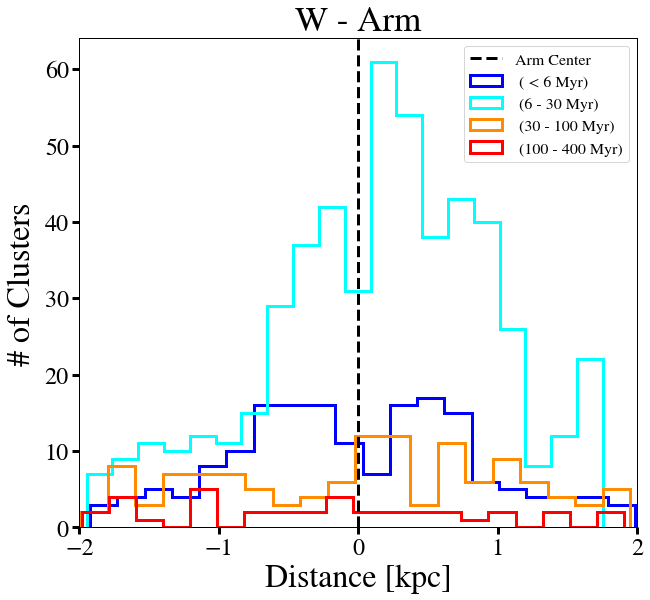

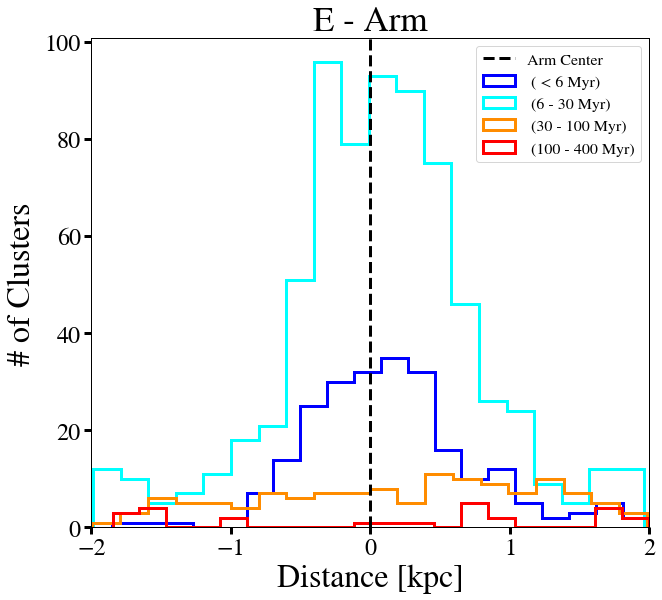

In [41]:
combined_histograms(W_data, 'W - Arm', 20, (10,9), 'W_combined.png')
combined_histograms(E_data, 'E - Arm', 20, (10,9), 'E_combined.png')

In [42]:
# Arm Segment Histograms
def theta_histograms(DATA, label_list, bn, figure_size, filename, cut, legloc, Norm=True):
    # DATA - the cluster data
    # label_list - list of arm segments you want to plot (equals columns)
    # rows - number of subplot rows
    # figure_size - tuple with figure size
    # bn - bin number
    # cut - in case thetas do not line up we need to add 360 degrees at the lowest angle
    #       where there is a separation
    # legloc - location of legend
    
    if cut != 0:
        w = DATA['Angle [deg]'] < cut
        DATA_L = DATA[w]
        for dat in DATA_L:
            dat['Angle [deg]'] = dat['Angle [deg]'] + 360
        w = DATA['Angle [deg]'] >= cut
        DATA_H = DATA[w]
        DATA = vstack([DATA_L,DATA_H])
        
        
    # age list
    age_L = [' ( < 6 Myr)', ' (6 - 30 Myr)', ' (30 - 100 Myr)', ' (100 - 400 Myr)']
    
    # Subplots
    fig = plt.figure(figsize=(figure_size), facecolor=(1, 1, 1))
    ecs = ['blue', 'cyan', 'darkorange', 'red']
    
    # filtering the data
    s_DATA = DATA
    w = s_DATA['best age'] < 6
    L6 = s_DATA[w]
    w = s_DATA['best age'] >= 6
    L30 = s_DATA[w]
    w = L30['best age'] < 30
    L30 = L30[w]
    w = s_DATA['best age'] >= 30
    L100 = s_DATA[w]
    w = L100['best age'] < 100
    L100 = L100[w]
    w = s_DATA['best age'] >= 100
    L400 = s_DATA[w]
    w = L400['best age'] <= 400
    L400 = L400[w]
    ages = [L6,L30,L100,L400]
        
    # plotting
    n=0
    if Norm==True:
        yl = '(%)'
    else:
        yl = '# of Clusters'
    t_string = label_list
    plt.title(t_string, fontsize=35)
    plt.xlabel(r"$\theta$ [Degrees]", fontsize = 32)
    plt.ylabel(yl, fontsize = 32, labelpad=8)
    plt.tick_params(axis='both', which='major', length=7, width=3, labelsize=24)
        
    while n < 4:
        t_table = ages[n]
        c_ang = t_table['Angle [deg]']
        #plt.xlim([-2, 2])
        plt.hist(c_ang, bins=bn, histtype="step", density=Norm, color='white',edgecolor=ecs[n], 
                 label=age_L[n], lw=3)
        plt.legend(fontsize=18, loc=legloc)
        n+=1
        
    fn = 'figures/' + filename
    fig.savefig(fn)
    return

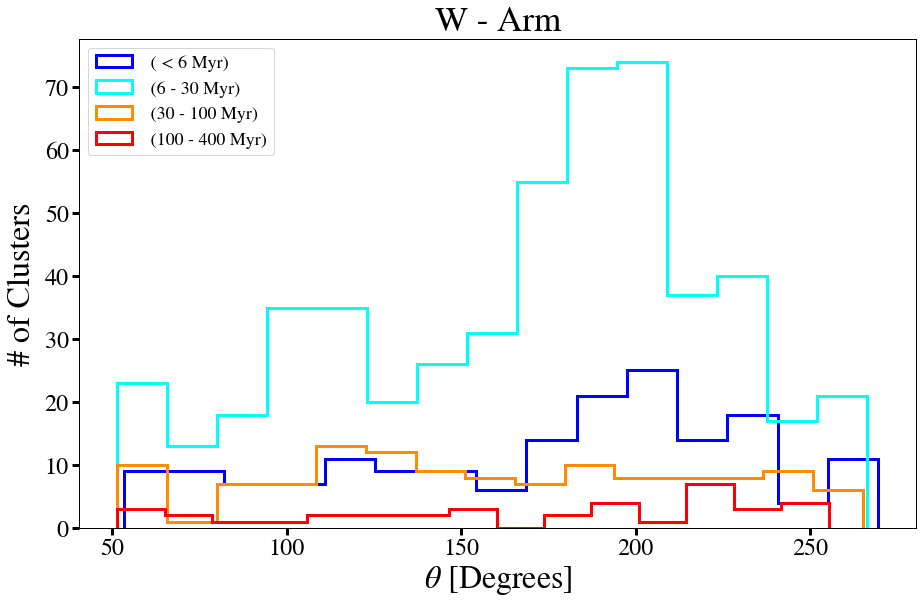

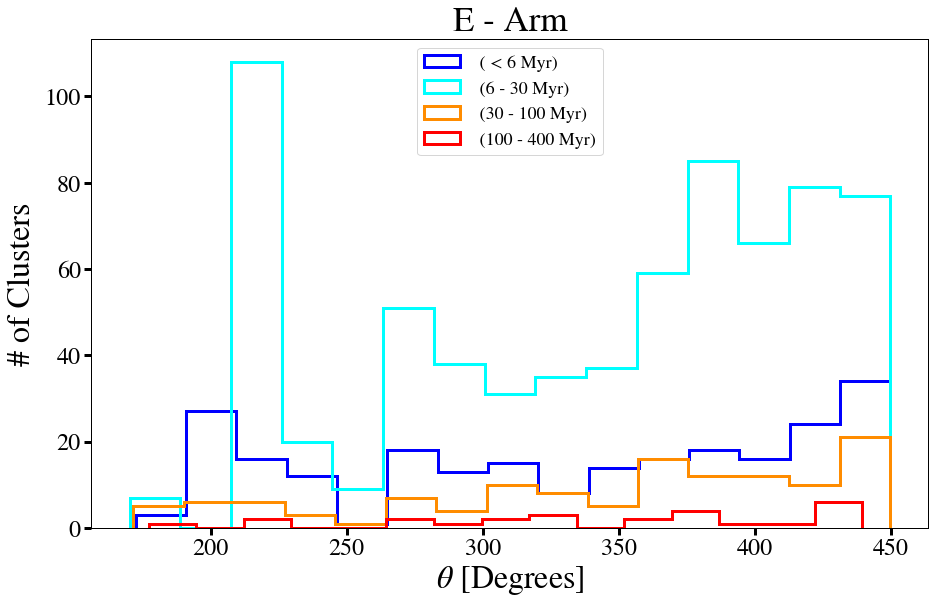

In [43]:
theta_histograms(W_data, 'W - Arm', 15, (15,9), 'W_theta.png', 0, "upper left", Norm=False)
theta_histograms(E_data, 'E - Arm', 15, (15,9), 'E_theta.png', 101, "upper center", Norm=False)

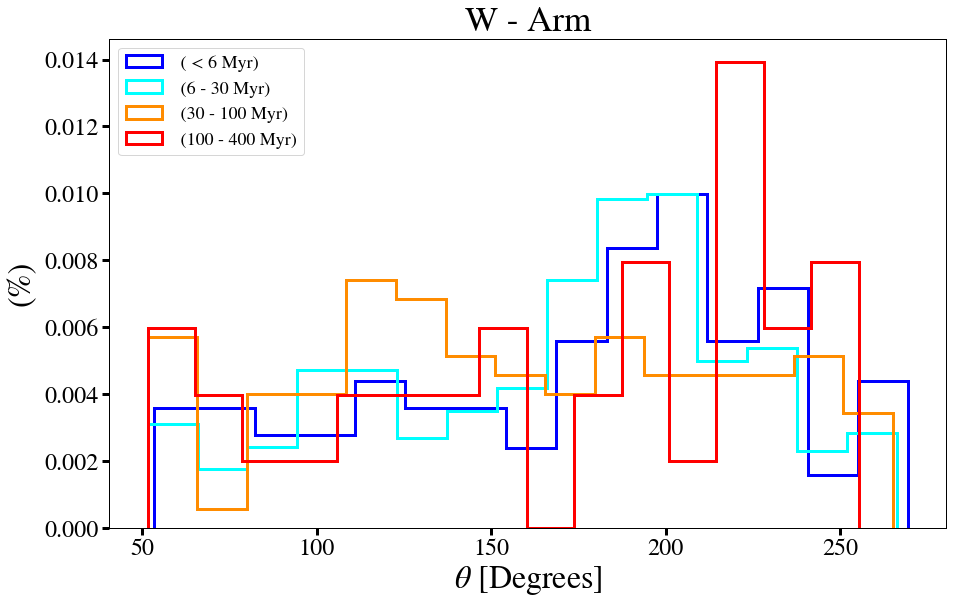

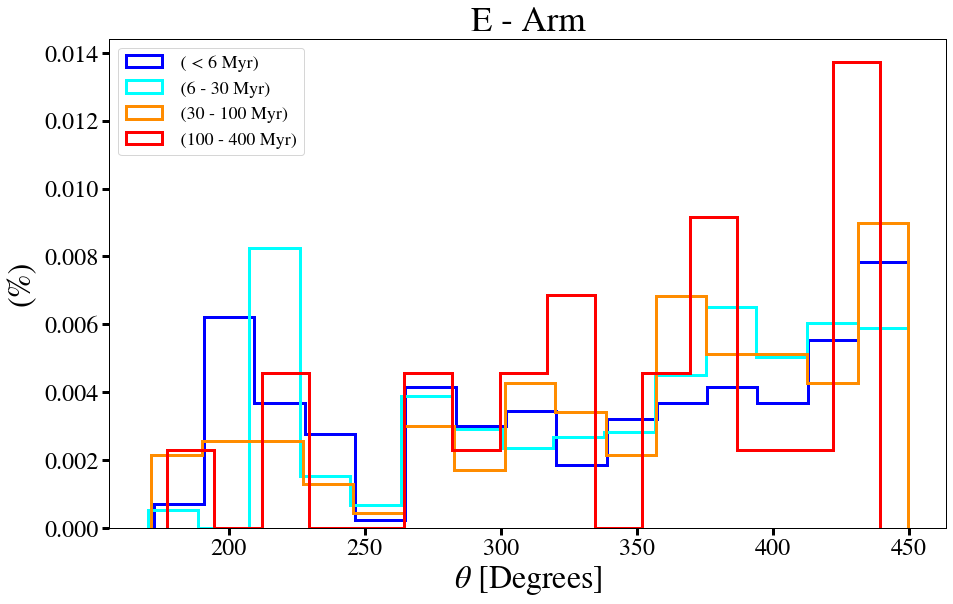

In [44]:
theta_histograms(W_data, 'W - Arm', 15, (15,9), 'W_theta_Norm.png', 0, "upper left", Norm=True)
theta_histograms(E_data, 'E - Arm', 15, (15,9), 'E_theta_Norm.png', 101, "upper left", Norm=True)

In [46]:
def stat_analysis(data, stat_type, segment_name):
    # stat_type: choose either distance or mass
    w = data['best age'] < 6
    L6 = data[w]
    w = data['best age'] >= 6
    L30 = data[w]
    w = L30['best age'] < 30
    L30 = L30[w]
    w = data['best age'] >= 30
    L100 = data[w]
    w = L100['best age'] < 100
    L100 = L100[w]
    w = data['best age'] >= 100
    L400 = data[w]
    w = L400['best age'] <= 400
    L400 = L400[w]
    ages = [L6,L30,L100,L400]
    age_list = []
    median = []
    mean = []
    sigma = []
    for a in  ages:
        data_type = a[stat_type]
        median.append(round(np.median(data_type), 6))
        mean.append(round(np.mean(data_type), 6))
        sigma.append(round(np.std(data_type), 6))
        
    print(segment_name)
    header = ['ages', 'mean ' + stat_type, 'median ' + stat_type, r'$\sigma$ ' + stat_type]
    age_l = ['< 6 Myr','6 - 30 Myr','30 - 100 Myr','100 - 400 Myr']
    arrays = [age_l, mean, median, sigma]
    analysis = Table(arrays, names=header)
    return analysis

In [47]:
# Example
W_table = stat_analysis(W_data, 'Dist [kpc]', 'West Distance Table')
W_table

West Distance Table


ages,mean Dist [kpc],median Dist [kpc],$\sigma$ Dist [kpc]
str13,float64,float64,float64
< 6 Myr,-0.006384,-0.093584,0.854428
6 - 30 Myr,0.158724,0.197902,0.805578
30 - 100 Myr,0.025075,0.146356,1.033819
100 - 400 Myr,-0.232757,-0.200775,1.058411


In [48]:
Wm_table = stat_analysis(W_data, 'mass', 'West Mass Table')
Wm_table

West Mass Table


ages,mean mass,median mass,$\sigma$ mass
str13,float64,float64,float64
< 6 Myr,11274.914368,5677.5,18923.955323
6 - 30 Myr,12981.342857,7195.0,19373.966066
30 - 100 Myr,38287.430894,28600.0,39284.213336
100 - 400 Myr,95949.621622,53960.0,94604.077278


In [49]:
E_table = stat_analysis(E_data, 'Dist [kpc]', 'East Distance Table')
E_table

East Distance Table


ages,mean Dist [kpc],median Dist [kpc],$\sigma$ Dist [kpc]
str13,float64,float64,float64
< 6 Myr,0.145586,0.10292,0.604285
6 - 30 Myr,0.070157,0.090407,0.705812
30 - 100 Myr,0.200962,0.363238,0.994919
100 - 400 Myr,0.137123,0.673023,1.339077


In [50]:
Em_table = stat_analysis(E_data, 'mass', 'East Distance Table')
Em_table

East Distance Table


ages,mean mass,median mass,$\sigma$ mass
str13,float64,float64,float64
< 6 Myr,11782.500426,5458.0,18610.710575
6 - 30 Myr,12875.116382,6838.0,21737.031394
30 - 100 Myr,46570.603175,27160.0,59442.035047
100 - 400 Myr,87936.8,60240.0,81387.116608


In [51]:
def mass_plots(data, arm_name, figure_size, filename):
    w = data['best age'] < 6
    L6 = data[w]
    w = data['best age'] >= 6
    L30 = data[w]
    w = L30['best age'] < 30
    L30 = L30[w]
    w = data['best age'] >= 30
    L100 = data[w]
    w = L100['best age'] < 100
    L100 = L100[w]
    w = data['best age'] >= 100
    L400 = data[w]
    w = L400['best age'] <= 400
    L400 = L400[w]
    age_L = ['( < 6 Myr)', '(6 - 30 Myr)', '(30 - 100 Myr)', '(100 - 400 Myr)']
    colors = ['blue', 'cyan', 'darkorange', 'red']
    ages = [L6,L30,L100,L400]
    
    fig, ax = plt.subplots(2, 2, figsize=(figure_size), facecolor=(1, 1, 1))

    t_string = arm_name + ' Mass Distribution ' + age_L[0]
    ax[0,0].scatter(L6['Dist [kpc]'], L6['mass']/1000, c='b', s=18)
    ax[0,0].set_title(t_string, fontsize=28,pad=12)
    ax[0,0].set_xlabel("Distance [kpc]", fontsize=25)
    ax[0,0].set_ylabel(r"Mass [$1000 \; M_{\odot}$]", fontsize=25)
    ax[0,0].axvline(0, c='k', ls='--', lw=5)

    t_string = arm_name + ' Mass Distribution ' + age_L[1]
    ax[0,1].scatter(L30['Dist [kpc]'], L30['mass']/1000, c='c', s=18)
    ax[0,1].set_title(t_string, fontsize=28, pad=12)
    ax[0,1].set_xlabel("Distance [kpc]", fontsize=25)
    ax[0,1].set_ylabel(r"Mass [$1000 \; M_{\odot}$]", fontsize=25)
    ax[0,1].axvline(0, c='k', ls='--', lw=5)

    t_string = arm_name + ' Mass Distribution ' + age_L[2]
    ax[1,0].scatter(L100['Dist [kpc]'], L100['mass']/1000, c='darkorange', s=18)
    ax[1,0].set_title(t_string, fontsize=28, pad=12)
    ax[1,0].set_xlabel("Distance [kpc]", fontsize=25)
    ax[1,0].set_ylabel(r"Mass [$1000 \; M_{\odot}$]", fontsize=25)
    ax[1,0].axvline(0, c='k', ls='--', lw=5)

    t_string = arm_name + ' Mass Distribution ' + age_L[3]
    ax[1,1].scatter(L400['Dist [kpc]'], L400['mass']/1000, c='r', s=18)
    ax[1,1].set_title(t_string, fontsize=28, pad=12)
    ax[1,1].set_xlabel("Distance [kpc]", fontsize=25)
    ax[1,1].set_ylabel(r"Mass [$1000 \; M_{\odot}$]", fontsize=25)
    ax[1,1].axvline(0, c='k', ls='--', lw=5)
        
    fn = 'figures/' + filename
    fig.savefig(fn)
    return

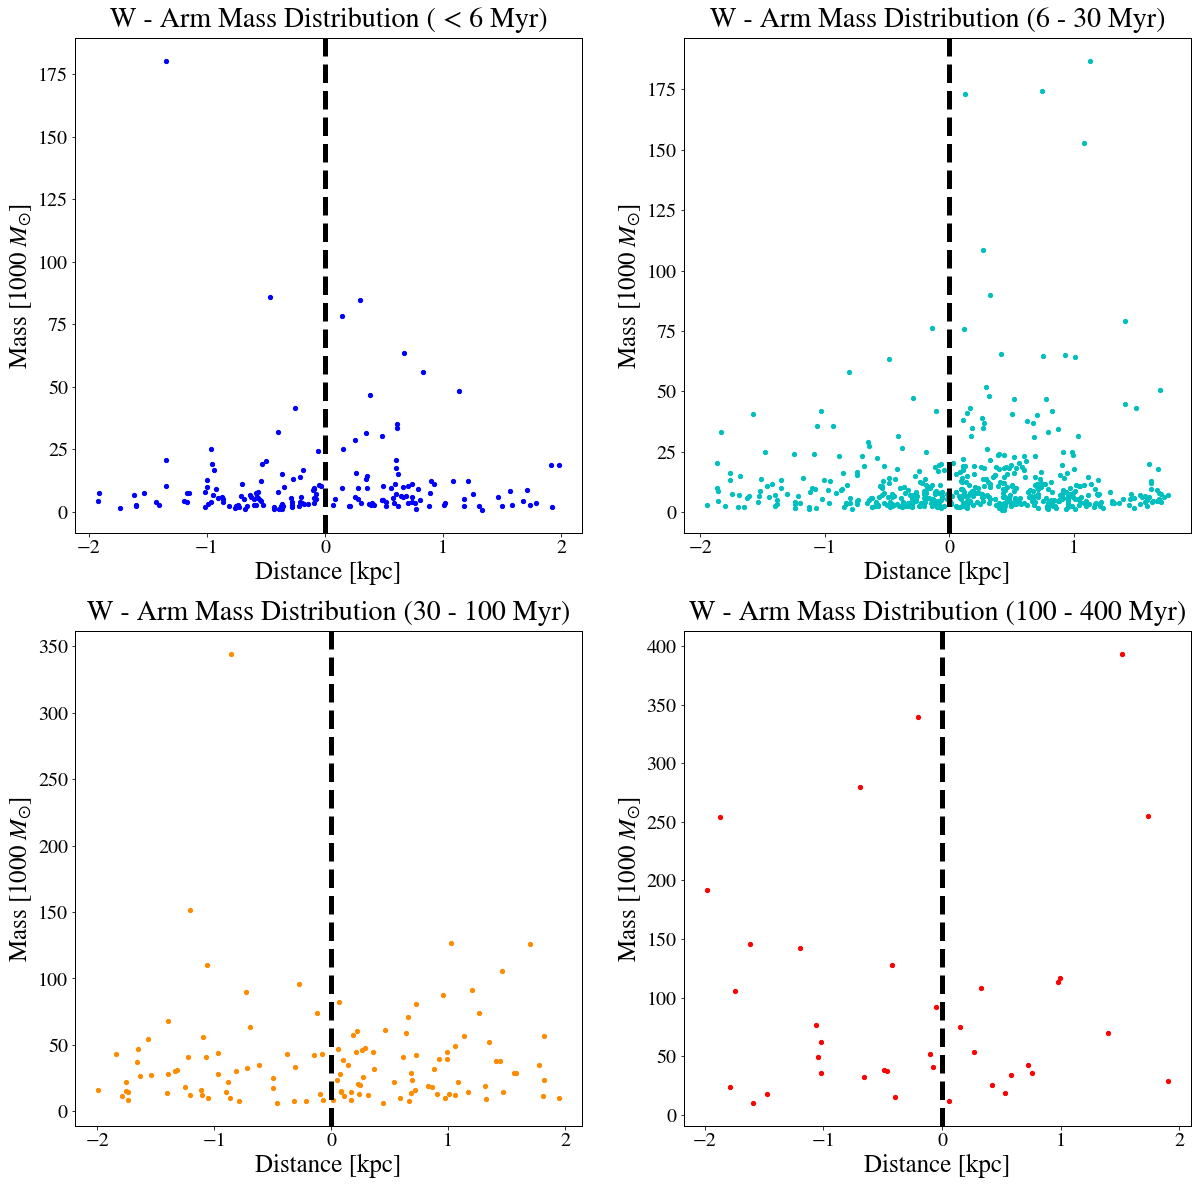

In [52]:
mass_plots(W_data, 'W - Arm', (20,20), 'W_mass_plot.png')

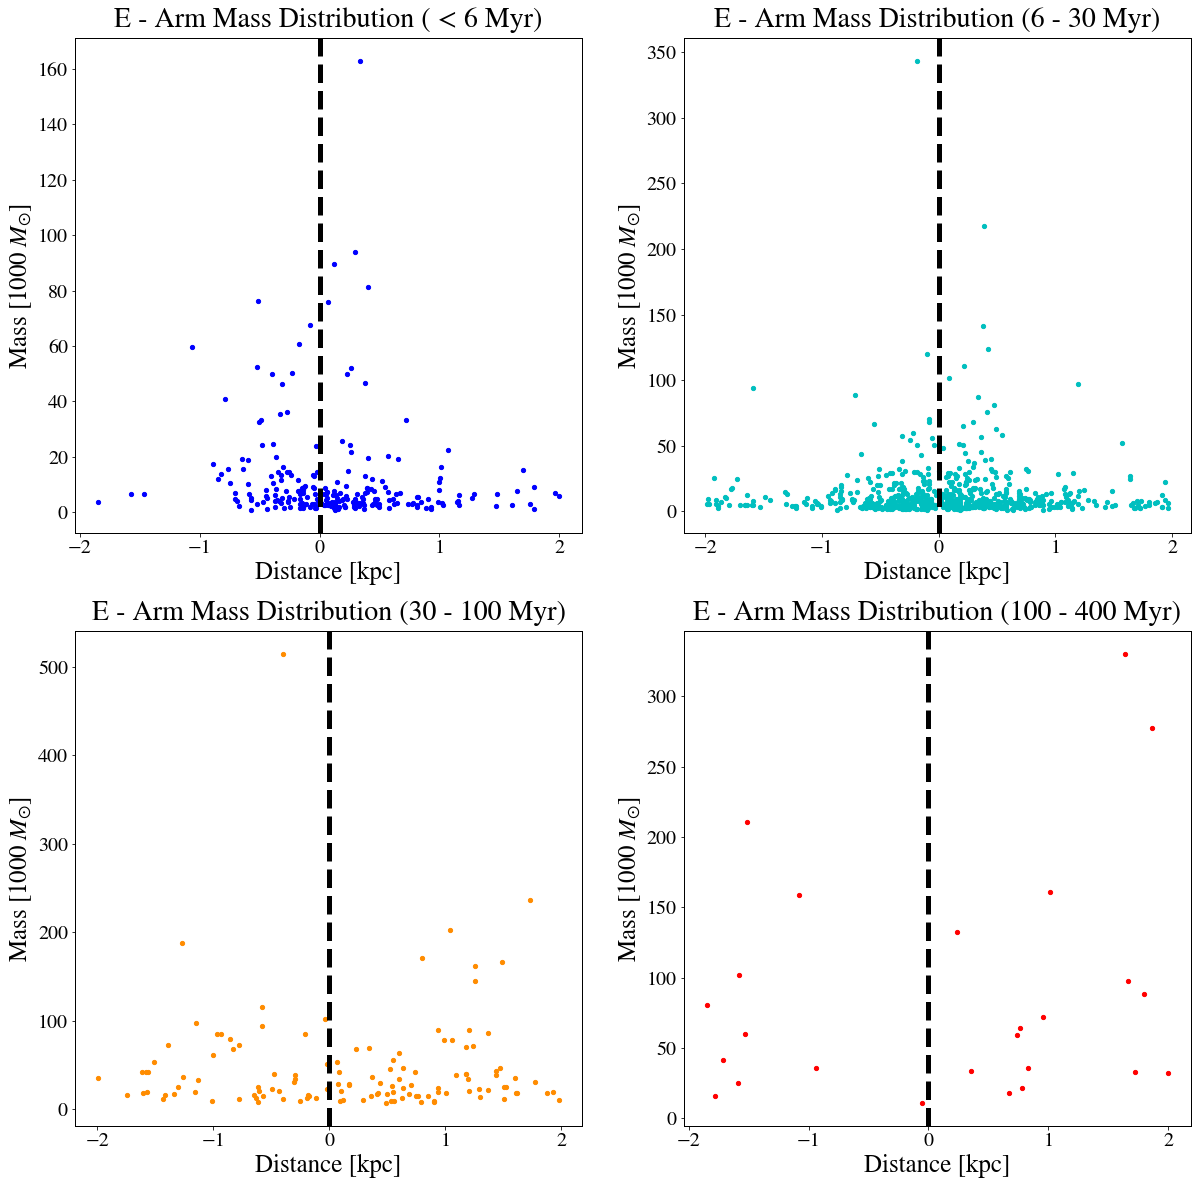

In [53]:
mass_plots(E_data, 'E - Arm', (20,20), 'E_mass_plot.png')